In [215]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

In [235]:
X_train = pd.read_csv('data/X_train.csv')

In [236]:
merchant_stats = X_train[X_train['is_fraud'] == 0].groupby('merchant').agg(mean_amt=('amt', np.mean), std_amt=('amt', np.std)).to_dict()
person_stats =X_train[X_train['is_fraud'] == 0].groupby('cc_num').agg(mean_amt=('amt', np.mean), std_amt=('amt', np.std)).to_dict()
user_merchant_stats = X_train[X_train['is_fraud'] == 0].groupby(['cc_num', 'merchant']).agg(mean_amt=('amt', np.mean), std_amt=('amt', np.std)).to_dict()

In [237]:
def transform(df):
    df['category'] = df['category'].map(lambda x: 1 if x in ('grocery_pos', 'misc_net', 'shopping_net', 'shopping_pos') else 0)
    df['hour'] = pd.to_datetime(df['unix_time'],unit='s').dt.hour
    df['gender'] = df['gender'].map(lambda x: 0 if x=='M' else 1)
    def add_merchant_outlier_column(df):
        zipped_merchant_amt_column = pd.Series(zip(df['merchant'], df['amt']))
        def merchant_outlier_column(merchant_amt):
            merchant, amt = merchant_amt
            if merchant not in merchant_stats['mean_amt'] or np.isnan(merchant_stats['std_amt'][merchant]):
                return 0
            mn, stddev = merchant_stats['mean_amt'][merchant], merchant_stats['std_amt'][merchant]
            return (abs(mn-amt))/stddev
        outlier_column = zipped_merchant_amt_column.map(merchant_outlier_column)
        df['merchant_outlier'] = outlier_column

    add_merchant_outlier_column(df)
    
    def add_user_outlier_column(df):
        zipped_user_amt_column = pd.Series(zip(df['cc_num'], df['amt']))
        def user_outlier_column(user_amt):
            user, amt = user_amt
            if user not in person_stats['mean_amt'] or np.isnan(person_stats['std_amt'][user]):
                return 0
            mn, stddev = person_stats['mean_amt'][user], person_stats['std_amt'][user]
            return (abs(mn-amt))/stddev
        outlier_column = zipped_user_amt_column.map(user_outlier_column)
        df['user_outlier'] = outlier_column

    add_user_outlier_column(df)
    
    def add_user_merchant_outlier_column(df):
        zipped_user_merchant_amt_column = pd.Series(zip(df['cc_num'], df['merchant'], df['amt']))
        def user_merchant_outlier_column(user_merchant_amt):
            user, merchant, amt = user_merchant_amt
            if (user, merchant) not in user_merchant_stats['mean_amt'] or np.isnan(user_merchant_stats['std_amt'][(user, merchant)]):
                return 0
            mn, stddev = user_merchant_stats['mean_amt'][(user, merchant)], user_merchant_stats['std_amt'][(user, merchant)]
            if stddev == 0:
                return 0
            return (abs(mn-amt))/stddev
        outlier_column = zipped_user_merchant_amt_column.map(user_merchant_outlier_column)
        df['user_merchant_outlier'] = outlier_column

    add_user_merchant_outlier_column(df)

In [238]:
transform(X_train)
X_train = X_train[['category', 'hour', 'gender', 'merchant_outlier', 'user_outlier', 'user_merchant_outlier', 'is_fraud']]
# X_train = X_train._get_numeric_data()

In [239]:
X_train, X_test, Y_train, Y_test = train_test_split(
        X_train.drop(['is_fraud'], axis=1),
        X_train['is_fraud'],
        test_size=1/5,
        random_state=0
    )

In [222]:
model = DecisionTreeClassifier().fit(X_train, Y_train)

In [223]:
predictions = model.predict(X_test)
print("Accuracy on testing set = ", accuracy_score(Y_test, predictions))
print("F1 score on testing set = ", f1_score(Y_test, predictions))

Accuracy on testing set =  0.9974190496755817
F1 score on testing set =  0.6769626769626771


In [224]:
predictions.sum(), len(predictions)

(410.0, 97251)

In [225]:
# load/transform testing data
X_test = pd.read_csv('data/X_test.csv')
submission = X_test[['Id']]
transform(X_test)
X_test = X_test[['category', 'hour', 'gender', 'merchant_outlier', 'user_outlier', 'user_merchant_outlier', 'is_fraud']]
# X_test = X_test._get_numeric_data()

In [226]:
predictions = model.predict(X_test.drop(columns='is_fraud'))

In [227]:
predictions.sum(), len(predictions)

(5077.0, 69465)

In [240]:
# more exploration
X_train

,category,hour,gender,merchant_outlier,user_outlier,user_merchant_outlier
239216,0,14,1,0.402590,0.129201,0.707107
55990,1,2,1,0.643857,0.317656,0.240673
348667,0,14,1,0.529077,0.485112,0.751969
79718,1,4,0,0.257508,0.882900,0.000000
118459,1,1,1,0.741638,0.884181,0.000000
...,...,...,...,...,...,...
439107,0,9,0,1.631794,0.273178,0.512592
117952,0,14,0,1.228940,4.862740,0.707107
435829,1,9,1,0.299494,0.593854,0.000000
305711,0,8,1,0.488397,0.091438,0.047295


In [337]:
# SVD?
u,s,vt_train = np.linalg.svd(X_train, full_matrices=False)

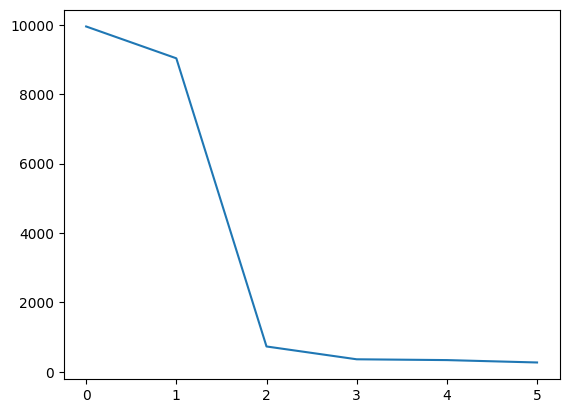

In [242]:
plt.plot(s)

In [295]:
s[2:] = 0
reduced_X_train = u@np.diag(s)@vt

In [296]:
reduced_X_train.shape

(389003, 6)

In [297]:
diffs = np.array(X_train) - reduced_X_train

In [298]:
norms = np.array(list(map(np.linalg.norm, diffs)))

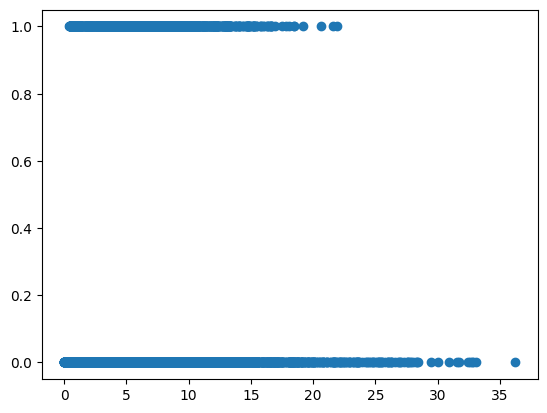

In [299]:
plt.scatter(norms, Y_train)

In [300]:
m,std = norms.mean(), norms.std()
m,std

(1.07175810865164, 1.0159547526284234)

In [301]:
frauds_norms = [norms[i] for i in range(len(norms)) if Y_train.iloc[i]==1]

In [309]:
print(len(frauds_norms))
print(len([i for i in frauds_norms if (i>m+2*std)]))

1510
1149


In [310]:
print(len(norms))
print(len([i for i in norms if (i>m+2*std)]))

389003
8831


In [338]:
u,s,vt = np.linalg.svd(X_test, full_matrices=False)

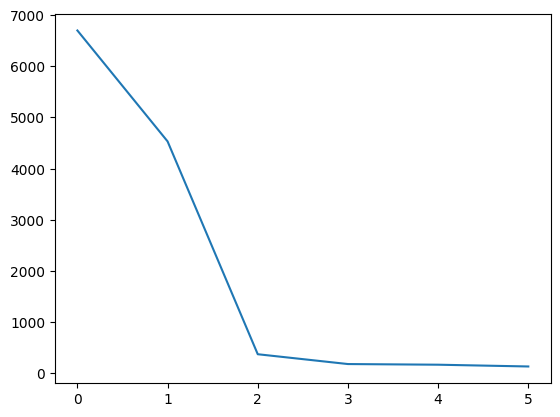

In [333]:
plt.plot(s)

In [340]:
s[3:] = 0
reduced_X_test = u@np.diag(s)@vt
diffs = np.array(X_test) - reduced_X_test
norms = np.array(list(map(np.linalg.norm, diffs)))
m,std = norms.mean(), norms.std()
frauds_norms = [norms[i] for i in range(len(norms)) if Y_test.iloc[i]==1]
print(len(frauds_norms))
print(len([i for i in frauds_norms if (i>m+2*std)]))
print(len(norms))
print(len([i for i in norms if (i>m+2*std)]))

367
249
97251
2135


In [342]:
(pd.Series([1,2,3,4,5])+5)/2

0    3.0
1    3.5
2    4.0
3    4.5
4    5.0
dtype: float64

In [344]:
X_train = pd.read_csv('data/X_train.csv')
X_train

,Id,cc_num,merchant,category,amt,first,last,gender,street,city,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_date,trans_time
0,205743,5.596350e+15,fraud_Berge LLC,gas_transport,72.18,Joseph,Moody,M,5901 Foster Pine,Kenner,...,68211,"Engineer, petroleum",23/04/1941,5223f3d810e0083482e47a5c3a1eba94,1378023768,30.424083,-90.080958,0.0,2020-09-01,08:22:00
1,465349,4.311370e+18,"fraud_Eichmann, Bogan and Rodriguez",gas_transport,36.66,Phillip,Delacruz,M,26678 Lisa Locks Apt. 904,Iliff,...,648,Community arts worker,21/09/1969,25f3a9b8613a9745c5802031bd3a2c62,1386834132,39.871664,-103.457961,0.0,2020-09-01,08:22:00
2,17312,2.264940e+15,fraud_Ankunding-Carroll,travel,1.74,Juan,Sherman,M,5939 Garcia Forges Suite 297,San Antonio,...,1595797,Land,17/10/1995,2a6f3f7c697bc721a80078aefd68d857,1372338223,28.456118,-98.491336,0.0,2020-09-01,08:22:00
3,234968,2.224100e+15,"fraud_Schumm, Bauch and Ondricka",grocery_pos,140.99,Sheri,Thomas,F,019 Kimberly Light Apt. 039,Kings Bay,...,1293,Naval architect,11/09/1963,fcd03eb50b00fe682d8a47f3bec089a6,1379131971,31.292136,-82.002506,0.0,2020-09-01,08:22:00
4,194255,3.527540e+15,fraud_Gerlach Inc,shopping_net,1722.19,Teresa,Stein,F,2838 White Fields Apt. 473,Brunson,...,1725,Social researcher,05/12/1974,d3105e269285b69b334e99433d6a6585,1377711655,33.067620,-80.201090,0.0,2020-09-01,08:22:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486249,502355,4.292900e+18,fraud_Wilkinson PLC,kids_pets,4.30,Jeffrey,Smith,M,135 Joseph Mountains,Sula,...,218,"Therapist, horticultural",16/08/1995,7e6011097067231cf9178de050f4dd4c,1387546102,46.332036,-114.660338,0.0,2020-09-01,08:22:00
486250,527890,2.131570e+14,fraud_Kuvalis Ltd,gas_transport,34.85,Adam,Santos,M,725 Jo Trace Apt. 102,Glendale,...,172817,Advertising account planner,30/07/1982,5f5926277386db598df3be7a7d5d491d,1388022446,33.229608,-118.386434,0.0,2020-09-01,08:22:00
486251,253663,6.763730e+11,"fraud_Hodkiewicz, Prohaska and Paucek",travel,9.22,Vicki,Mendoza,F,3645 Atkins Island Apt. 238,Esbon,...,242,Tourism officer,18/07/1987,04b32f0a628784474a8f48f977605c4d,1379807336,39.316927,-97.617048,0.0,2020-09-01,08:22:00
486252,33882,3.026700e+13,fraud_Kihn-Fritsch,food_dining,9.39,Sarah,Foster,F,77872 Andrea Glen Apt. 543,Ford,...,1051,Chief Operating Officer,21/11/1976,cfe6c288ba518822c1b6822515a165e1,1372807037,37.084437,-78.715023,0.0,2020-09-01,08:22:00
